In [93]:
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.model_selection import KFold
from sklearn.datasets import make_classification
from timerun import time_code, time_func
import time
import matplotlib.pyplot as plt
import numpy as np
from multiprocessing import Pool
from parallel_methods import DSMethods
from sklearn.utils import resample
import math

In [94]:
def plot_train_vs_test(train_scores, test_scores, spoint = None, wo = None, points = {}, time = -1, tvar = -1):
    if points != {}: plt.scatter(points.keys(), points.values(), marker='|', zorder = 3)
    plt.plot(train_scores.keys(), train_scores.values(), label = "Train", zorder = 2)
    plt.plot(test_scores.keys(), test_scores.values(), label = "Test", zorder = 1)
    
    xleft, xright = plt.xlim()
    if spoint and wo:
        plt.scatter(spoint[0], spoint[1], s=10, c='red')
        w = [-wo[1]/n_features, wo[0]]
        b = w[0]*spoint[0] + w[1]*spoint[1]
        xleft, xright = plt.xlim()
        xd = np.array([xleft, xright])
        yd = [(b - w[0]*xd[0]) / w[1], (b - w[0]*xd[1]) / w[1]]
        plt.plot(xd, yd, lw=1, c='red')
    
    plt.legend()
    plt.ylim([0.4,1.0])
    plt.xlim([xleft, xright])
    plt.axhline(0.5, color = "red", linewidth=1, linestyle="--")

    plt.show()

    print("AT", spoint, "WITH", len(points), "ITERATIONS IN", time, "SECONDS :", tvar)

def scal(data, w):
    obj = np.array([w[0] * (1 - acc) + w[1] * (i / n_features) for i, acc in data.items()])
    spoint_x = list(data.keys())[np.argmin(obj)]
    spoint_y = data[spoint_x]
    return (spoint_x, spoint_y, obj[np.argmin(obj)])

def mean_of_arrays(data):
    arr = {}
    for x in data[0]:
        arr[x] = np.mean([data[v][x] for v in data])
    return arr

In [95]:
n_features = 300
X, y = make_classification(n_samples = 2000, n_features = n_features, n_informative = 100, n_clusters_per_class=10, n_redundant=100, n_repeated=0, flip_y=0.01, random_state=2, class_sep=3)
X_train, X_test = np.split(X, [500])
y_train, y_test = np.split(y, [500])
data = DSMethods(n_features, X_train, y_train, X_test, y_test)

# Random selection

In [96]:
@time_func
def RANDOM_SELECTION(CVal = 0.1, kernel='liblinear', w1 = [0.8, 0.2]):
    data.kernel = kernel
    data.C = CVal
    with Pool(7) as pool:
        scores = pool.map(data.randomSelection, [CVal]*10)
    
    #scores = list(map(data.randomSelection, [0.1]))

    train_scores = mean_of_arrays({i: x[0] for i, x in enumerate(scores)})
    test_scores  = mean_of_arrays({i: x[1] for i, x in enumerate(scores)})
    time         = np.mean([x[2] for x in scores])
    plot_train_vs_test(train_scores, test_scores, scal(test_scores, w1), w1)

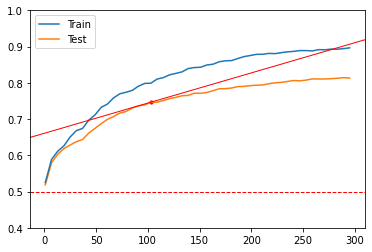

AT (103, 0.7465999999999999, 0.2713866666666667) WITH 0 ITERATIONS IN -1 SECONDS : -1
__main__.RANDOM_SELECTION - 00:00:04.598292400


In [97]:
RANDOM_SELECTION(0.00001)

# SVM-RFE

In [98]:
@time_func
def SVM_RFE_W_STEP(step = 10, percentage = 0.5, C = 0.5, kernel = 'liblinear', w1 = [0.8, 0.2], gamma = 1.0, degree=6):
    data.kernel = 'precomputed'
    data.kernel_matrix = kernel
    data.C = C
    data.gamma = gamma
    data.degree = degree
    kf = KFold(n_splits=7, shuffle=True)

    index = [(train_index, test_index, step) for train_index, test_index in kf.split(data.X_train)]
    with Pool(7) as pool:
        scores = pool.map(data.svm_rfe_kernel, index)

    #scores = list(map(data.svm_rfe_kernel, index))
    scores = list(scores)

    train_scores = mean_of_arrays({i: x[0] for i, x in enumerate(scores)})
    test_scores  = mean_of_arrays({i: x[1] for i, x in enumerate(scores)})
    points       = mean_of_arrays({i: x[2] for i, x in enumerate(scores)})
    time         = np.mean([x[3] for x in scores])
    tvar         = np.var([x[3] for x in scores])

    print(kernel, C, degree, gamma)
    plot_train_vs_test(train_scores, test_scores, scal(test_scores, w1), w1, points, time, tvar)
    return scal(test_scores, w1), time

poly 0.0001 1 1.0


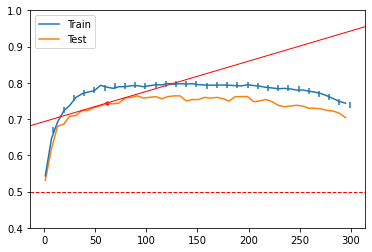

AT (61, 0.7439637826961771, 0.245495640509725) WITH 30 ITERATIONS IN 47.21271429743086 SECONDS : 6.532826395618824
__main__.SVM_RFE_W_STEP - 00:00:53.199347200


((61, 0.7439637826961771, 0.245495640509725), 47.21271429743086)

In [99]:
SVM_RFE_W_STEP(kernel='poly', degree=1, C=0.0001)

poly 1e-10 1 1.0


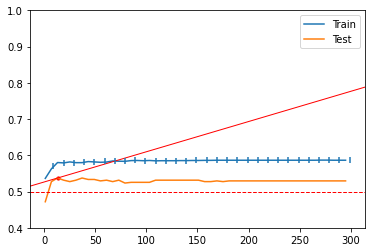

AT (13, 0.5373630672926447, 0.3787762128325509) WITH 30 ITERATIONS IN 47.6093157018934 SECONDS : 2.1150772398822695
__main__.SVM_RFE_W_STEP - 00:00:52.851675200
poly 1e-09 1 1.0


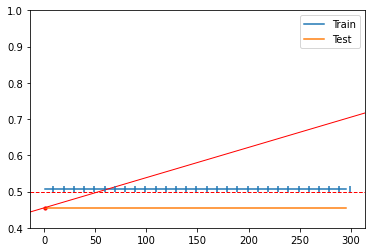

AT (1, 0.4560138609434383, 0.43585557791191604) WITH 30 ITERATIONS IN 51.18243394579206 SECONDS : 5.336149693602414
__main__.SVM_RFE_W_STEP - 00:00:57.069347000
poly 1e-08 1 1.0


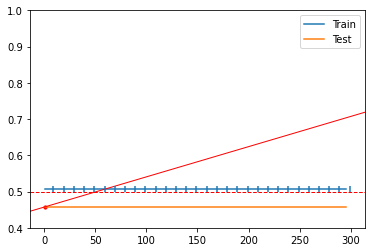

AT (1, 0.4581097697294881, 0.43417885088307623) WITH 30 ITERATIONS IN 49.33833139283316 SECONDS : 9.002618284439786
__main__.SVM_RFE_W_STEP - 00:00:56.172279200
poly 1e-07 1 1.0


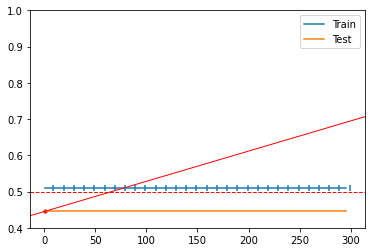

AT (1, 0.44578582606751616, 0.44403800581265374) WITH 30 ITERATIONS IN 49.02265954017639 SECONDS : 3.163712899556864
__main__.SVM_RFE_W_STEP - 00:00:54.857826200
poly 1e-06 1 1.0


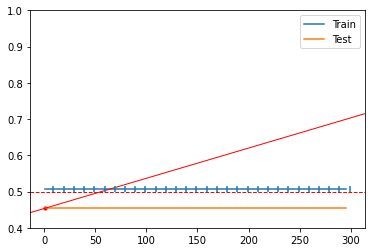

AT (1, 0.4541694612117147, 0.43733109769729495) WITH 30 ITERATIONS IN 51.579868010112214 SECONDS : 10.026275323999045
__main__.SVM_RFE_W_STEP - 00:00:58.952675400
poly 1e-05 1 1.0


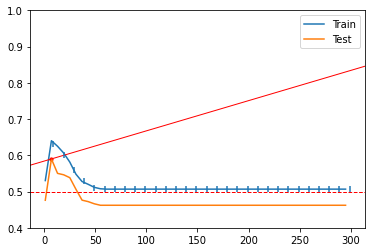

AT (7, 0.5900402414486922, 0.33263447350771297) WITH 30 ITERATIONS IN 53.2712973185948 SECONDS : 6.227767958350371
__main__.SVM_RFE_W_STEP - 00:00:59.810796300
poly 0.0001 1 1.0


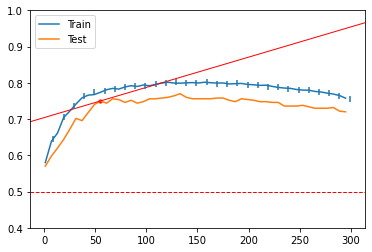

AT (55, 0.7500279454504807, 0.23664431030628214) WITH 30 ITERATIONS IN 49.130759954452515 SECONDS : 8.619241242809055
__main__.SVM_RFE_W_STEP - 00:00:55.878912100
poly 0.001 1 1.0


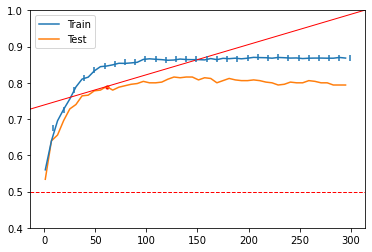

AT (61, 0.7898781578359042, 0.20876414039794333) WITH 30 ITERATIONS IN 50.915513787950786 SECONDS : 3.6650184089437907
__main__.SVM_RFE_W_STEP - 00:00:56.835018200
poly 0.01 1 1.0


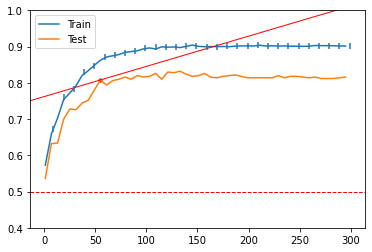

AT (55, 0.8079588642968923, 0.1902995752291528) WITH 30 ITERATIONS IN 48.97276905604771 SECONDS : 7.493756978316266
__main__.SVM_RFE_W_STEP - 00:00:55.865277600
poly 0.1 1 1.0


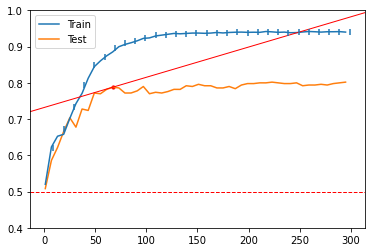

AT (67, 0.7878940308517773, 0.2143514419852448) WITH 30 ITERATIONS IN 52.3614752973829 SECONDS : 3.7421329637704686
__main__.SVM_RFE_W_STEP - 00:00:58.366033500
poly 1e-10 2 1.0


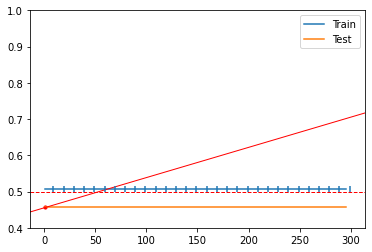

AT (1, 0.45606975184439974, 0.4358108651911469) WITH 30 ITERATIONS IN 48.374988658087595 SECONDS : 2.033087147788184
__main__.SVM_RFE_W_STEP - 00:00:54.058549700
poly 1e-09 2 1.0


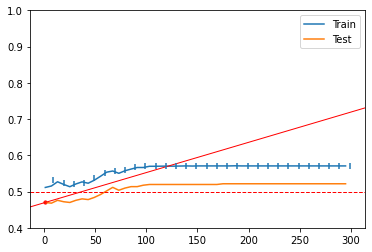

AT (1, 0.4699865861837692, 0.4246773977196513) WITH 30 ITERATIONS IN 48.31697654724121 SECONDS : 7.949570194099059
__main__.SVM_RFE_W_STEP - 00:00:55.003386400
poly 1e-08 2 1.0


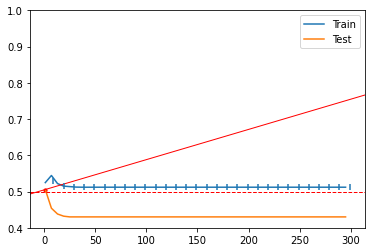

AT (1, 0.5056449809970937, 0.39615068186899177) WITH 30 ITERATIONS IN 53.185509647641865 SECONDS : 5.476168162467931
__main__.SVM_RFE_W_STEP - 00:00:59.477987800
poly 1e-07 2 1.0


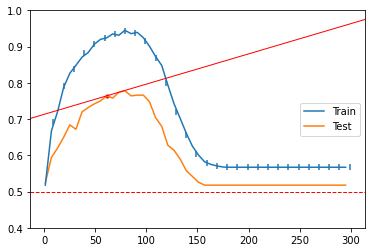

AT (61, 0.7640286161412922, 0.2294437737536329) WITH 30 ITERATIONS IN 52.52623105049133 SECONDS : 10.165744361770603
__main__.SVM_RFE_W_STEP - 00:01:00.004194700
poly 1e-06 2 1.0


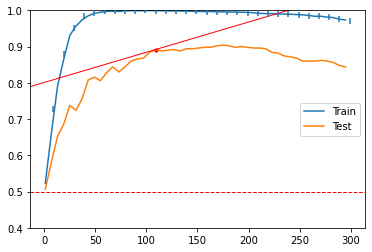

AT (109, 0.8919628884417616, 0.15909635591325738) WITH 30 ITERATIONS IN 54.38764572143555 SECONDS : 12.62007259473007
__main__.SVM_RFE_W_STEP - 00:01:02.278060000
poly 1e-05 2 1.0


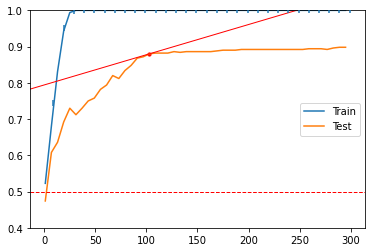

AT (103, 0.8800860719874805, 0.1645978090766823) WITH 30 ITERATIONS IN 53.83462756020682 SECONDS : 4.313885021555698
__main__.SVM_RFE_W_STEP - 00:01:00.031146800
poly 0.0001 2 1.0


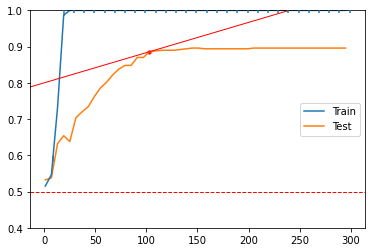

AT (103, 0.8859266711379388, 0.15992532975631565) WITH 30 ITERATIONS IN 50.59463735989162 SECONDS : 11.661355628194968
__main__.SVM_RFE_W_STEP - 00:00:57.999019700
poly 0.001 2 1.0


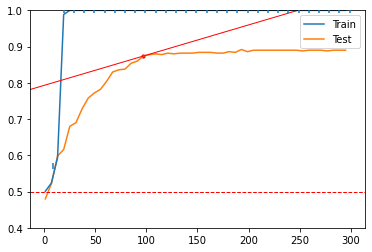

AT (97, 0.8739660183322154, 0.16549385200089434) WITH 30 ITERATIONS IN 50.858677421297344 SECONDS : 3.4708357791589024
__main__.SVM_RFE_W_STEP - 00:00:57.103386900
poly 0.01 2 1.0


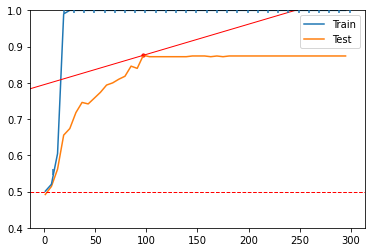

AT (97, 0.8760339816677843, 0.1638394813324392) WITH 30 ITERATIONS IN 48.04192818914141 SECONDS : 7.2930001141485565
__main__.SVM_RFE_W_STEP - 00:00:55.525362900
poly 0.1 2 1.0


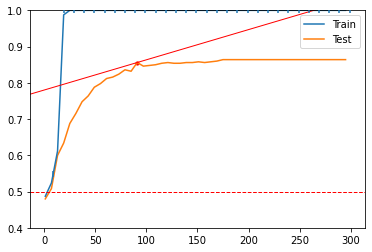

AT (91, 0.856080930024592, 0.17580192264699313) WITH 30 ITERATIONS IN 47.305742672511506 SECONDS : 6.5903570270689675
__main__.SVM_RFE_W_STEP - 00:00:54.099199900
poly 1e-10 3 1.0


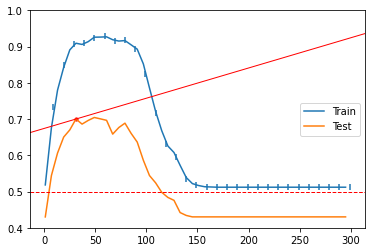

AT (31, 0.7001173708920189, 0.26057276995305156) WITH 30 ITERATIONS IN 76.22024376051766 SECONDS : 2.499031750854584
__main__.SVM_RFE_W_STEP - 00:01:22.233863100
poly 1e-09 3 1.0


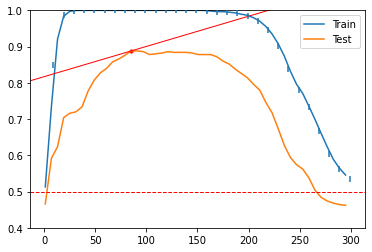

AT (85, 0.8879946344735077, 0.14627095908786053) WITH 30 ITERATIONS IN 73.98822055544171 SECONDS : 2.4343149677961406
__main__.SVM_RFE_W_STEP - 00:01:19.899857300
poly 1e-08 3 1.0


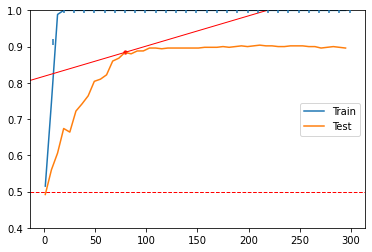

AT (79, 0.8840543259557344, 0.14542320590207913) WITH 30 ITERATIONS IN 75.94544771739415 SECONDS : 1.7613604280223922
__main__.SVM_RFE_W_STEP - 00:01:21.528592500
poly 1e-07 3 1.0


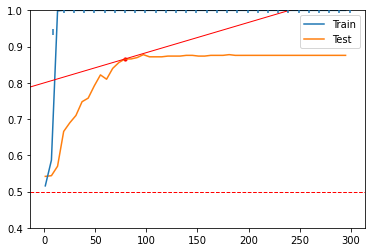

AT (79, 0.8658897831433043, 0.15995484015202321) WITH 30 ITERATIONS IN 68.66178093637738 SECONDS : 1.435086984655005
__main__.SVM_RFE_W_STEP - 00:01:14.190750700
poly 1e-06 3 1.0


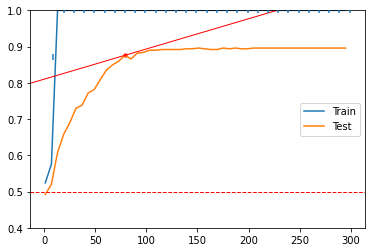

AT (79, 0.8760060362173038, 0.15186183769282366) WITH 30 ITERATIONS IN 67.18156470571246 SECONDS : 0.4922311598929299
__main__.SVM_RFE_W_STEP - 00:01:11.838859400
poly 1e-05 3 1.0


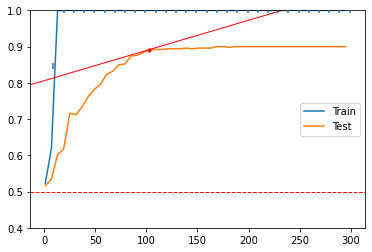

AT (103, 0.8919069975408004, 0.15514106863402638) WITH 30 ITERATIONS IN 66.72360937935966 SECONDS : 0.7542194410422863
__main__.SVM_RFE_W_STEP - 00:01:11.597585000
poly 0.0001 3 1.0


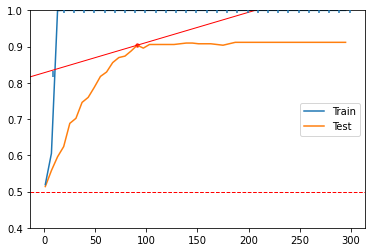

AT (91, 0.9038676503465235, 0.13757254638944788) WITH 30 ITERATIONS IN 67.25777421678815 SECONDS : 0.5275124634019394
__main__.SVM_RFE_W_STEP - 00:01:12.127688300
poly 0.001 3 1.0


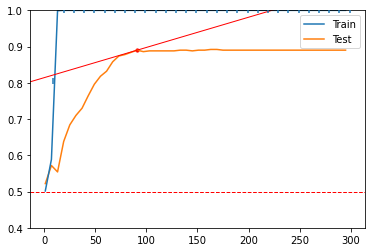

AT (91, 0.89020232506148, 0.14850480661748267) WITH 30 ITERATIONS IN 66.5325573512486 SECONDS : 0.5948457260493546
__main__.SVM_RFE_W_STEP - 00:01:11.279984500
poly 0.01 3 1.0


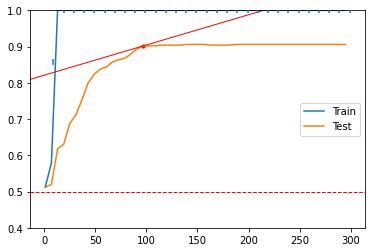

AT (97, 0.9020511960652805, 0.14302570981444226) WITH 30 ITERATIONS IN 66.1493217263903 SECONDS : 1.0304230787982032
__main__.SVM_RFE_W_STEP - 00:01:11.396277200
poly 0.1 3 1.0


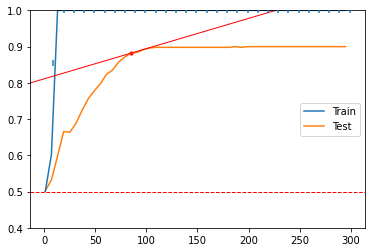

AT (85, 0.8819863626201654, 0.15107757657053436) WITH 30 ITERATIONS IN 66.02287561552865 SECONDS : 0.7074465897726233
__main__.SVM_RFE_W_STEP - 00:01:10.722564200


In [100]:
model_selection = {}
for d in [1, 2, 3]:
    for C in [10**-10, 10**-9, 10**-8, 10**-7, 10**-6, 10**-5, 10**-4, 10**-3, 10**-2, 10**-1]:
        model_selection[C, d] = SVM_RFE_W_STEP(kernel='poly', degree=d, C=C)

In [103]:
lines = {}
for C, d in model_selection:
    lines[C] = ['\\textbf{' + "{:.0e}".format(C) + '}', '', '', '']

for C, d in model_selection:
    col = {1: 1, 2: 2, 3: 3}
    if d in col.keys():
        v = model_selection[C, d]
        lines[C][col[d]] = "  {:>3s} & {:.2f}\\% & {:.3f}".format(str(v[0][0]), 100 * v[0][1], v[0][2])

for line in lines.values():
    print(' & '.join(line) + '\\\\')

\textbf{1e-10} &    13 & 53.74\% & 0.379 &     1 & 45.61\% & 0.436 &    31 & 70.01\% & 0.261\\
\textbf{1e-09} &     1 & 45.60\% & 0.436 &     1 & 47.00\% & 0.425 &    85 & 88.80\% & 0.146\\
\textbf{1e-08} &     1 & 45.81\% & 0.434 &     1 & 50.56\% & 0.396 &    79 & 88.41\% & 0.145\\
\textbf{1e-07} &     1 & 44.58\% & 0.444 &    61 & 76.40\% & 0.229 &    79 & 86.59\% & 0.160\\
\textbf{1e-06} &     1 & 45.42\% & 0.437 &   109 & 89.20\% & 0.159 &    79 & 87.60\% & 0.152\\
\textbf{1e-05} &     7 & 59.00\% & 0.333 &   103 & 88.01\% & 0.165 &   103 & 89.19\% & 0.155\\
\textbf{1e-04} &    55 & 75.00\% & 0.237 &   103 & 88.59\% & 0.160 &    91 & 90.39\% & 0.138\\
\textbf{1e-03} &    61 & 78.99\% & 0.209 &    97 & 87.40\% & 0.165 &    91 & 89.02\% & 0.149\\
\textbf{1e-02} &    55 & 80.80\% & 0.190 &    97 & 87.60\% & 0.164 &    97 & 90.21\% & 0.143\\
\textbf{1e-01} &    67 & 78.79\% & 0.214 &    91 & 85.61\% & 0.176 &    85 & 88.20\% & 0.151\\


In [104]:
lines = {}
for C, d in model_selection:
    lines[C] = ['\\textbf{' + "{:.0e}".format(C) + '}', '', '', '']

for C, d in model_selection:
    col = {1: 1, 2: 2, 3: 3}
    if d in col.keys():
        v = model_selection[C, d]
        lines[C][col[d]] = "{:.0f}:{:0>2s}.{:0>3s}".format(math.floor(v[1]/60.0), str(int(v[1] % 60)), str(int((v[1] % 1) * 1000)))

for line in lines.values():
    print(' & '.join(line) + '\\\\')

\textbf{1e-10} & 0:47.609 & 0:48.374 & 1:16.220\\
\textbf{1e-09} & 0:51.182 & 0:48.316 & 1:13.988\\
\textbf{1e-08} & 0:49.338 & 0:53.185 & 1:15.945\\
\textbf{1e-07} & 0:49.022 & 0:52.526 & 1:08.661\\
\textbf{1e-06} & 0:51.579 & 0:54.387 & 1:07.181\\
\textbf{1e-05} & 0:53.271 & 0:53.834 & 1:06.723\\
\textbf{1e-04} & 0:49.130 & 0:50.594 & 1:07.257\\
\textbf{1e-03} & 0:50.915 & 0:50.858 & 1:06.532\\
\textbf{1e-02} & 0:48.972 & 0:48.041 & 1:06.149\\
\textbf{1e-01} & 0:52.361 & 0:47.305 & 1:06.022\\
